# Cronenberg Movie Assistent 

## Importing dependencies

In [1]:

import json
import os
import numpy as np
import random
import matplotlib.pyplot as plt



## Loading files paths


In [5]:

train_paths = []
trainset_path = '../../dstc8-schema-guided-dialogue/train/'
for file in os.listdir(trainset_path):
    if file != 'schema.json':
        with open(os.path.join(trainset_path, file), 'r') as json_file:
            for example in json.load(json_file):
                train_paths.append(example)


test_paths = []
testset_path = '../../dstc8-schema-guided-dialogue/test/'
for file in os.listdir(testset_path):
    if file != 'schema.json':
        with open(os.path.join(testset_path, file), 'r') as json_file:
            for example in json.load(json_file):
                test_paths.append(example)

## Parsing data 

In [6]:


train_sentences_0 = []
train_sentences_1 = []

others_train_sentences = []
none_train_sentences = []

intents = {'FindMovies':0, 'PlayMovie':0, 'NONE':0, 'others':0}
for dialogue in train_paths:
    for idx in range(0, len(dialogue['turns']), 2):
        sentence = dialogue['turns'][idx]['utterance']
        intent = dialogue['turns'][idx]['frames'][0]['state']['active_intent']

        if intent not in ['FindMovies', 'PlayMovie', 'NONE']:
          intents['others'] += 1
          others_train_sentences.append(sentence)
          pass
        else:
          if intent == 'FindMovies':
            intents['FindMovies'] += 1
            train_sentences_0.append(sentence)
          elif intent == 'PlayMovie':
            intents['PlayMovie'] += 1
            train_sentences_1.append(sentence)
          else:
            none_train_sentences.append(sentence)
            intents['NONE'] += 1
#print(intents)
#print(len(train_sentences_0),len(train_sentences_1), len(none_train_sentences),len(others_train_sentences))
#plt.bar(intents.keys(), intents.values(), 1.0, color='g')
            




In [7]:

test_intents = []
test_sentences_0 = []
test_sentences_1 = []

others_test_sentences = []
none_test_sentences = []
for dialogue in test_paths:

    for idx in range(0, len(dialogue['turns']), 2):
        sentence = dialogue['turns'][idx]['utterance']
        intent = dialogue['turns'][idx]['frames'][0]['state']['active_intent']

        if intent not in ['FindMovies', 'PlayMovie', 'NONE']:
          others_test_sentences.append(sentence)
          pass
        else:
          if intent == 'FindMovies':
        
            test_sentences_0.append(sentence)
          elif intent == 'PlayMovie':
        
            test_sentences_1.append(sentence)
          else:
            none_test_sentences.append(sentence)
            
print(intents)
print(len(test_sentences_0),len(test_sentences_1), len(none_test_sentences),len(others_test_sentences))

{'FindMovies': 6179, 'PlayMovie': 2579, 'NONE': 11971, 'others': 144253}
1744 824 2911 36818


## Balacing dataset

2579
12895 12895


(array([2579.,    0.,    0., 2579.,    0.,    0., 2579.,    0.,    0.,
        5158.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

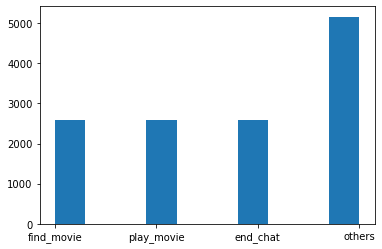

In [8]:
min_val = min(intents.values())
print(min_val)

input_train = []
target_train = []


input_train.extend(train_sentences_0[:min_val])
target_train.extend(["find_movie" for _ in range(min_val)])


input_train.extend(train_sentences_1[:min_val])
target_train.extend(["play_movie" for _ in range(min_val)])



input_train.extend(none_train_sentences[:min_val])
target_train.extend(["end_chat" for _ in range(min_val)])

input_train.extend(others_train_sentences[:2*min_val])
target_train.extend(["others" for _ in range(2*min_val)])


print(len(input_train), len(target_train))
#print(input_train[12672], target_train[12672])
plt.hist(target_train)


In [9]:


input_test = []
target_test = []


input_test.extend(test_sentences_0)
target_test.extend(["find_movie" for _ in range(len(test_sentences_0))])

input_test.extend(test_sentences_1)
target_test.extend(["play_movie" for _ in range(len(test_sentences_1))])

input_test.extend(none_test_sentences)
target_test.extend(["end_chat" for _ in range(len(none_test_sentences))])


input_test.extend(others_test_sentences[:3*len(test_sentences_1)])
target_test.extend(["others" for _ in range(3*len(test_sentences_1))])

print(len(input_test),len(target_test))

7951 7951


## Tokenizing

In [10]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

max_num_words = 40000
classes = ['find_movie',"play_movie","end_chat","others"]

tokenizer = Tokenizer(num_words=max_num_words)
tokenizer.fit_on_texts(input_train)
word_index = tokenizer.word_index

In [11]:
ls=[]
for c in input_train:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))
train_sequences = tokenizer.texts_to_sequences(input_train)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen,              padding='post')

test_sequences = tokenizer.texts_to_sequences(input_test)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')


## Enconding

In [12]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoder.fit(integer_encoded)
train_label_encoded = label_encoder.transform(target_train)
train_label_encoded = train_label_encoded.reshape(len(train_label_encoded), 1)
train_label = onehot_encoder.transform(train_label_encoded)


test_labels_encoded = label_encoder.transform(target_test)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels = onehot_encoder.transform(test_labels_encoded)




In [15]:
import wget
url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
wget.download(url)

'glove.6B.100d.txt'

In [13]:
embeddings_index={}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [14]:

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['the'])
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


/home/dclm/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


## Creating Model

In [15]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional,Embedding
from tensorflow.nn import leaky_relu
classes = np.array(classes)
model = Sequential()

model.add(Embedding(num_words, 100, trainable=False,input_length=train_sequences.shape[1], weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(512, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.2))
model.add(Dense(50, activation=leaky_relu))
model.add(Dropout(0.2))
model.add(Dense(classes.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

## Training

In [16]:
history = model.fit(train_sequences, train_label, epochs = 1,
          batch_size = 64, shuffle=True, validation_data=[test_sequences,test_labels])

202/202 [==============================] - 27s 136ms/step - loss: 0.9163 - acc: 0.6261 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00


## Saving

In [23]:
import pickle
import json
model.save('models/intents.h5')

with open('utils/classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open('utils/tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('utils/label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

## Testing

In [17]:
import numpy as np
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        return self.label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [18]:
import pickle

from tensorflow.python.keras.models import load_model
import tensorflow.nn as nn
model = load_model('models/intents_new.h5',custom_objects={'leaky_relu': nn.leaky_relu})

with open('utils/classes_new.pkl','rb') as file:
  classes = pickle.load(file)

with open('utils/tokenizer_new.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open('utils/label_encoder_new.pkl','rb') as file:
  label_encoder = pickle.load(file)

In [19]:
def decode(label):
    if label == 0:
        return "find_movie"
    if label == 1: 
        return "play_movie"
    if label == 2:
        return "end_chat"
    else:
        return "other"
phrase = "I wanna watch a horror movie"
nlu = IntentClassifier(classes,model,tokenizer,label_encoder)
label = nlu.get_intent(phrase)
print("Phrase: {}".format(phrase))
print("Predicted intent: {}".format((label)))

Phrase: I wanna watch a horror movie
Predicted intent: find_movie
